In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sklearn
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/sl-gene-expression/14cancer.xtrain
/kaggle/input/sl-gene-expression/14cancer.ytrain


# General Functions

In [2]:
def kmeans_model_predict(x, n_cluster, init='random', n_init=5, max_iter=1000):
    km = KMeans(n_clusters=n_cluster, init=init, n_init=n_init, max_iter=max_iter)
    return km.fit_predict(x), km.inertia_

In [3]:
def output_creation(clusters, cancer_categories_df, cancer_labels):
    cancer_clustering_df = cancer_categories_df.T
    cancer_clustering_df.columns = ['CancerType']
    cancer_clustering_df['Cluster'] = clusters.T
    cluster_counts_list = []
    for cluster in cancer_clustering_df['Cluster'].unique():
        count_values = cancer_clustering_df[cancer_clustering_df['Cluster'] == cluster ].groupby(['CancerType']).count()['Cluster']
        cancer_cluster_obj = {}
        for i in range(1,len(cancer_labels)+1,1):
            if i in count_values.index:
                cancer_cluster_obj[cancer_labels[i-1]] = count_values[i]
            else:
                cancer_cluster_obj[cancer_labels[i-1]] = 0
        #print(cancer_cluster_obj)
        cluster_counts_list.append(cancer_cluster_obj)
    #print(cluster_counts_list)
    return cluster_counts_list

In [88]:
def create_cluster_string(clusters_number, experiments_number):
    cluster_list = []
    for e in range(1, experiments_number + 1):
        for c in range(1, clusters_number + 1):
            cluster_list.append(f"Cluster{c}_Test{e}")
    return cluster_list

# Data Acquisition

### Gene Dataset

In [4]:
gene_train_df = pd.read_csv('/kaggle/input/sl-gene-expression/14cancer.xtrain', header=None, delim_whitespace=True)

In [5]:
gene_train_df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,134,135,136,137,138,139,140,141,142,143
0,-73,-16,4,-31,-33,-37,-18,-26,-40,22,...,274,-96,-96,-124,-201,-196,34,-56,-245,-26
1,-69,-63,-45,-110,-39,-90,28,-23,-264,-14,...,-915,-221,-458,-664,-259,-369,-81,-818,-235,-1595
2,-48,-97,-112,-20,-45,-75,10,2,-335,-21,...,-303,-119,-134,-361,22,-263,-146,-1338,-127,-2085
3,13,-42,-25,-50,14,-46,30,34,18,26,...,29,243,109,21,140,162,-151,-57,197,-334
4,-86,-91,-85,-115,-56,-45,-56,-54,-163,-42,...,-171,-224,-630,-519,-277,-277,-174,-989,-562,-455
5,-147,-164,-127,-113,-106,-129,-200,-30,-208,-38,...,-217,-366,-369,-412,-373,-615,-121,-796,-714,-354
6,-65,-53,56,-17,73,87,149,-12,138,-60,...,-958,-291,-1407,-39,263,-397,-290,-1466,-1621,-482
7,-71,-77,-110,-40,-34,-49,-87,-25,-113,-39,...,-320,-69,-337,-279,-82,-243,-106,-347,-226,196
8,-32,-17,81,-17,18,50,-2,-6,16,21,...,-166,-39,-294,6,100,70,43,-413,-35,114
9,100,122,41,80,64,3,95,69,-15,64,...,268,4,351,424,346,-167,240,103,-243,45


In [6]:
gene_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16063 entries, 0 to 16062
Columns: 144 entries, 0 to 143
dtypes: float64(1), int64(143)
memory usage: 17.6 MB


In [7]:
gene_train_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,134,135,136,137,138,139,140,141,142,143
count,16063.000000,16063.000000,16063.000000,16063.000000,16063.000000,16063.000000,16063.000000,16063.000000,16063.000000,16063.000000,...,16063.000000,16063.000000,16063.000000,16063.000000,16063.000000,16063.000000,16063.000000,16063.000000,16063.000000,16063.000000
mean,26.599950,23.171388,81.767540,31.268879,167.069974,74.395816,82.844923,33.377825,264.759260,31.306792,...,638.439706,354.352798,912.274731,378.876860,259.743946,458.837764,160.001245,598.945776,293.960095,164.547158
std,251.664362,228.725250,469.891508,233.358432,611.572681,443.675660,468.294695,187.341336,962.057611,265.719834,...,1462.490383,1046.445591,2008.482183,1139.403996,900.029931,1175.377003,588.505841,1499.979802,914.750927,747.615951
min,-3830.000000,-4327.000000,-2375.000000,-2133.000000,-2778.000000,-5524.000000,-3943.000000,-909.000000,-3895.000000,-1265.000000,...,-4513.000000,-11743.000000,-6873.000000,-9655.000000,-7405.000000,-11261.000000,-3480.000000,-6818.000000,-7479.000000,-6978.000000
25%,-38.000000,-29.000000,-19.000000,-18.000000,5.000000,-9.000000,-16.000000,-5.000000,-4.000000,-9.000000,...,23.000000,9.000000,11.000000,-8.000000,-14.000000,2.000000,-7.000000,-1.000000,-12.000000,-22.000000
50%,8.000000,10.000000,19.000000,13.000000,47.000000,19.000000,20.000000,11.000000,63.000000,8.000000,...,202.000000,126.000000,206.000000,108.000000,83.000000,158.000000,47.000000,150.000000,91.000000,41.000000
75%,65.000000,57.000000,75.000000,49.000000,147.000000,62.000000,72.000000,33.000000,236.000000,33.000000,...,734.000000,394.000000,1038.000000,417.000000,291.000000,556.000000,171.000000,701.000000,349.000000,190.000000
max,12577.000000,13111.000000,17258.000000,16144.000000,14917.000000,17061.000000,16766.000000,12874.000000,24741.000000,17861.000000,...,30117.000000,19868.000000,25205.000000,21274.000000,16444.000000,19158.000000,18270.000000,21524.000000,19556.000000,18310.000000


### Cancer categories dataset

In [8]:
cancer_categories_df = pd.read_csv('/kaggle/input/sl-gene-expression/14cancer.ytrain', header=None, delim_whitespace=True)

In [9]:
cancer_categories_df.head()

,0,1,2,3,4,5,6,7,8,9,...,134,135,136,137,138,139,140,141,142,143
0,1,1,1,1,1,1,1,1,2,2,...,14,14,14,14,14,14,14,14,14,14


# Data Cleaning

### Rename columns

In [10]:
# Gene dataset & Cancer categories dataset
new_columns = []
for i in range(1,len(gene_train_df.columns) + 1, 1):
    new_columns.append(f"Patient{i}")
gene_train_df.columns = new_columns
cancer_categories_df.columns = new_columns

# Data Enrichment

# Final Dataset

### Gene dataset

In [11]:
gene_train_df.head()

,Patient1,Patient2,Patient3,Patient4,Patient5,Patient6,Patient7,Patient8,Patient9,Patient10,...,Patient135,Patient136,Patient137,Patient138,Patient139,Patient140,Patient141,Patient142,Patient143,Patient144
0,-73,-16,4,-31,-33,-37,-18,-26,-40,22,...,274,-96,-96,-124,-201,-196,34,-56,-245,-26
1,-69,-63,-45,-110,-39,-90,28,-23,-264,-14,...,-915,-221,-458,-664,-259,-369,-81,-818,-235,-1595
2,-48,-97,-112,-20,-45,-75,10,2,-335,-21,...,-303,-119,-134,-361,22,-263,-146,-1338,-127,-2085
3,13,-42,-25,-50,14,-46,30,34,18,26,...,29,243,109,21,140,162,-151,-57,197,-334
4,-86,-91,-85,-115,-56,-45,-56,-54,-163,-42,...,-171,-224,-630,-519,-277,-277,-174,-989,-562,-455


In [12]:
gene_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16063 entries, 0 to 16062
Columns: 144 entries, Patient1 to Patient144
dtypes: float64(1), int64(143)
memory usage: 17.6 MB


In [13]:
gene_train_df.describe()

,Patient1,Patient2,Patient3,Patient4,Patient5,Patient6,Patient7,Patient8,Patient9,Patient10,...,Patient135,Patient136,Patient137,Patient138,Patient139,Patient140,Patient141,Patient142,Patient143,Patient144
count,16063.000000,16063.000000,16063.000000,16063.000000,16063.000000,16063.000000,16063.000000,16063.000000,16063.000000,16063.000000,...,16063.000000,16063.000000,16063.000000,16063.000000,16063.000000,16063.000000,16063.000000,16063.000000,16063.000000,16063.000000
mean,26.599950,23.171388,81.767540,31.268879,167.069974,74.395816,82.844923,33.377825,264.759260,31.306792,...,638.439706,354.352798,912.274731,378.876860,259.743946,458.837764,160.001245,598.945776,293.960095,164.547158
std,251.664362,228.725250,469.891508,233.358432,611.572681,443.675660,468.294695,187.341336,962.057611,265.719834,...,1462.490383,1046.445591,2008.482183,1139.403996,900.029931,1175.377003,588.505841,1499.979802,914.750927,747.615951
min,-3830.000000,-4327.000000,-2375.000000,-2133.000000,-2778.000000,-5524.000000,-3943.000000,-909.000000,-3895.000000,-1265.000000,...,-4513.000000,-11743.000000,-6873.000000,-9655.000000,-7405.000000,-11261.000000,-3480.000000,-6818.000000,-7479.000000,-6978.000000
25%,-38.000000,-29.000000,-19.000000,-18.000000,5.000000,-9.000000,-16.000000,-5.000000,-4.000000,-9.000000,...,23.000000,9.000000,11.000000,-8.000000,-14.000000,2.000000,-7.000000,-1.000000,-12.000000,-22.000000
50%,8.000000,10.000000,19.000000,13.000000,47.000000,19.000000,20.000000,11.000000,63.000000,8.000000,...,202.000000,126.000000,206.000000,108.000000,83.000000,158.000000,47.000000,150.000000,91.000000,41.000000
75%,65.000000,57.000000,75.000000,49.000000,147.000000,62.000000,72.000000,33.000000,236.000000,33.000000,...,734.000000,394.000000,1038.000000,417.000000,291.000000,556.000000,171.000000,701.000000,349.000000,190.000000
max,12577.000000,13111.000000,17258.000000,16144.000000,14917.000000,17061.000000,16766.000000,12874.000000,24741.000000,17861.000000,...,30117.000000,19868.000000,25205.000000,21274.000000,16444.000000,19158.000000,18270.000000,21524.000000,19556.000000,18310.000000


### Cancer categories dataset

In [14]:
cancer_categories_df.head(10)

,Patient1,Patient2,Patient3,Patient4,Patient5,Patient6,Patient7,Patient8,Patient9,Patient10,...,Patient135,Patient136,Patient137,Patient138,Patient139,Patient140,Patient141,Patient142,Patient143,Patient144
0,1,1,1,1,1,1,1,1,2,2,...,14,14,14,14,14,14,14,14,14,14


In [15]:
cancer_categories_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Columns: 144 entries, Patient1 to Patient144
dtypes: int64(144)
memory usage: 1.2 KB


In [16]:
cancer_categories_df.describe()

,Patient1,Patient2,Patient3,Patient4,Patient5,Patient6,Patient7,Patient8,Patient9,Patient10,...,Patient135,Patient136,Patient137,Patient138,Patient139,Patient140,Patient141,Patient142,Patient143,Patient144
count,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
mean,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,...,14.0,14.0,14.0,14.0,14.0,14.0,14.0,14.0,14.0,14.0
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,...,14.0,14.0,14.0,14.0,14.0,14.0,14.0,14.0,14.0,14.0
25%,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,...,14.0,14.0,14.0,14.0,14.0,14.0,14.0,14.0,14.0,14.0
50%,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,...,14.0,14.0,14.0,14.0,14.0,14.0,14.0,14.0,14.0,14.0
75%,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,...,14.0,14.0,14.0,14.0,14.0,14.0,14.0,14.0,14.0,14.0
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,...,14.0,14.0,14.0,14.0,14.0,14.0,14.0,14.0,14.0,14.0


In [17]:
cancer_labels = [
    'breast',
    'prostate',
    'lung',
    'collerectal',
    'lymphoma',
    'bladder',
    'melanoma',
    'uterus',
    'leukemia',
    'renal',
    'pancreas',
    'ovary',
    'meso',
    'cns'
]

# Data visualization

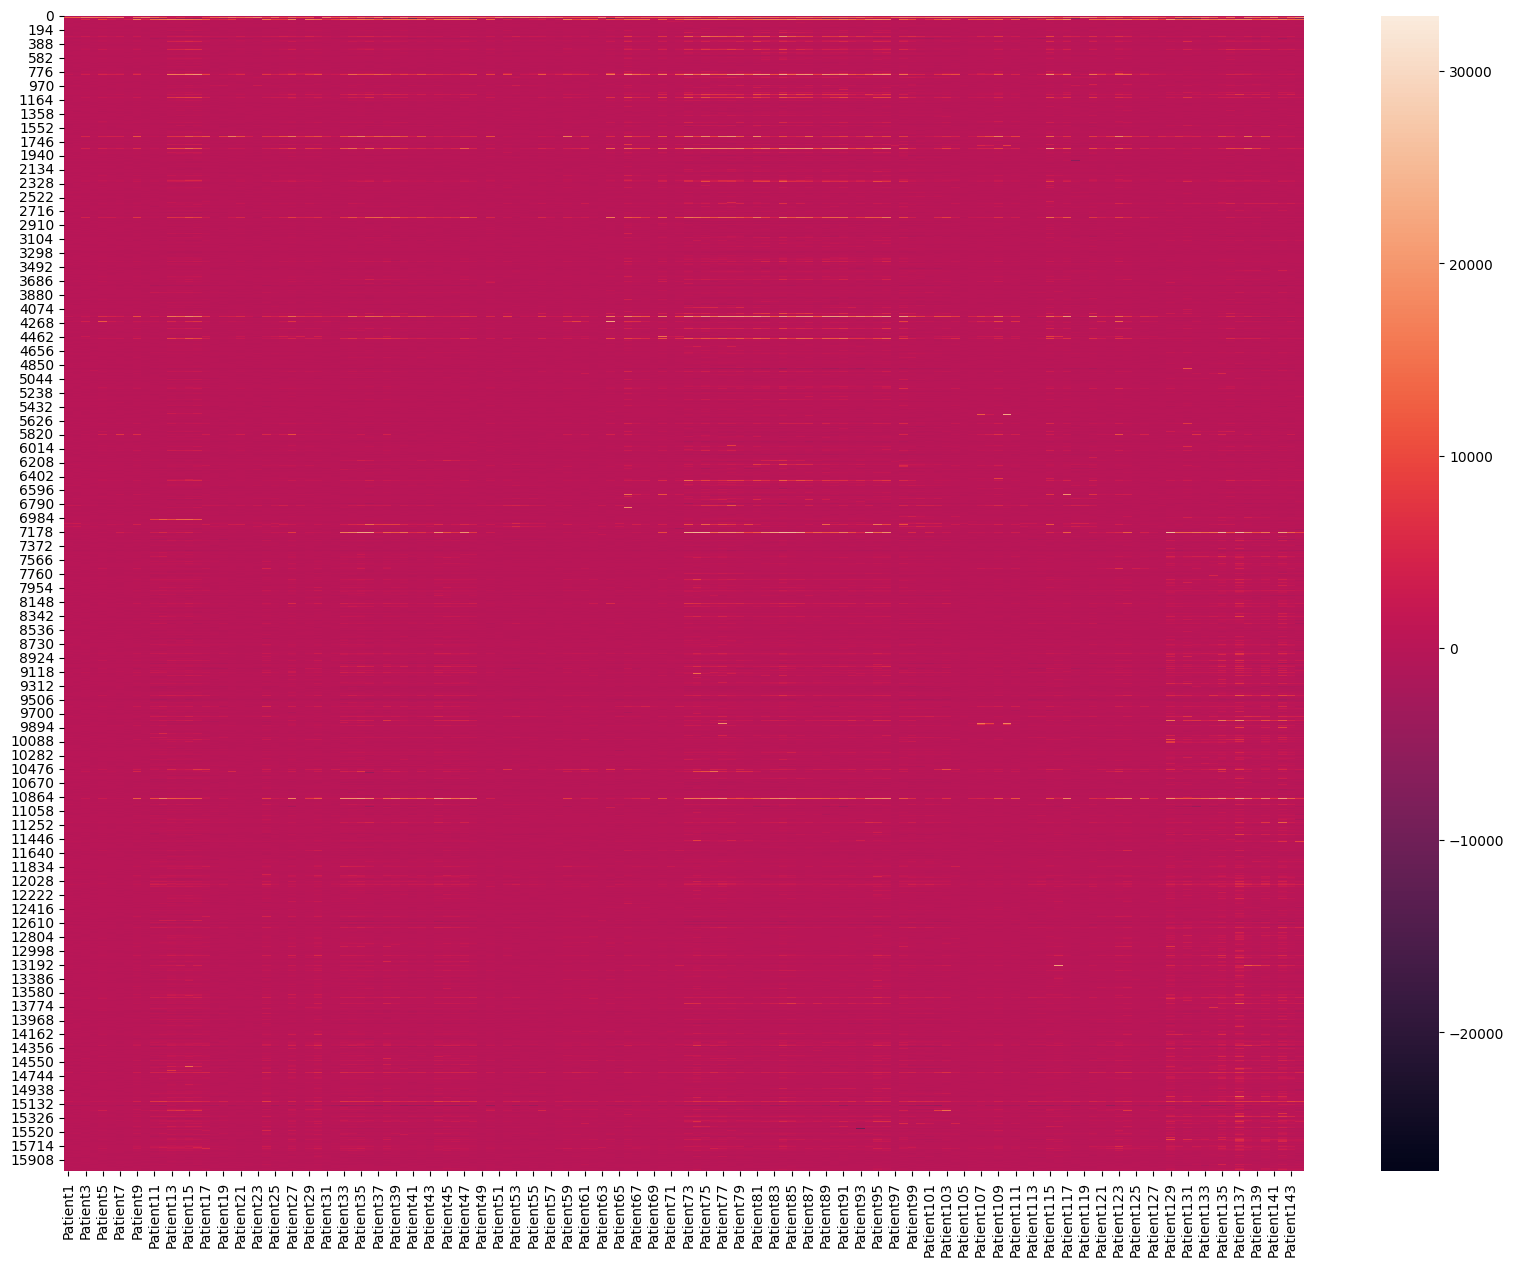

In [18]:
plt.figure(figsize=(20,15))
sb.heatmap(gene_train_df)
plt.show()

# Clustering - KMeans - Test

In [19]:
# K-means ++ --> n_init=1
kmeans_model = KMeans(n_clusters=2, init='random', n_init=10, max_iter=1000, random_state=42)

In [20]:
clusters = kmeans_model.fit_predict(gene_train_df.T)

In [21]:
kmeans_model.inertia_

865755593329.0791

In [22]:
len(clusters)

144

In [23]:
clusters

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [24]:
cancer_clustering_df = cancer_categories_df.T

In [25]:
cancer_clustering_df.columns = ['CancerType']

In [26]:
cancer_clustering_df['Cluster'] = clusters.T

In [27]:
cancer_clustering_df

,CancerType,Cluster
Patient1,1,0
Patient2,1,0
Patient3,1,0
Patient4,1,0
Patient5,1,0
...,...,...
Patient140,14,0
Patient141,14,0
Patient142,14,0
Patient143,14,0


In [28]:
cancer_clustering_df.groupby(['Cluster']).count()

,CancerType
Cluster,
0,93
1,51


In [29]:
cancer_count_bycluster = pd.DataFrame(columns=cancer_labels)

In [30]:
cancer_count_bycluster

,breast,prostate,lung,collerectal,lymphoma,bladder,melanoma,uterus,leukemia,renal,pancreas,ovary,meso,cns


In [31]:
cluster_counts_list = []
for cluster in cancer_clustering_df['Cluster'].unique():
    count_values = cancer_clustering_df[cancer_clustering_df['Cluster'] == cluster ].groupby(['CancerType']).count()['Cluster']
    cancer_cluster_obj = {}
    for i in range(1,len(cancer_labels)+1,1):
        if i in count_values.index:
            cancer_cluster_obj[cancer_labels[i-1]] = count_values[i]
        else:
            cancer_cluster_obj[cancer_labels[i-1]] = 0
    #print(cancer_cluster_obj)
    cluster_counts_list.append(cancer_cluster_obj)

In [32]:
cluster_counts_list

[{'breast': 8,
  'prostate': 4,
  'lung': 8,
  'collerectal': 7,
  'lymphoma': 6,
  'bladder': 8,
  'melanoma': 7,
  'uterus': 5,
  'leukemia': 0,
  'renal': 7,
  'pancreas': 7,
  'ovary': 5,
  'meso': 6,
  'cns': 15},
 {'breast': 0,
  'prostate': 4,
  'lung': 0,
  'collerectal': 1,
  'lymphoma': 10,
  'bladder': 0,
  'melanoma': 1,
  'uterus': 3,
  'leukemia': 24,
  'renal': 1,
  'pancreas': 1,
  'ovary': 3,
  'meso': 2,
  'cns': 1}]

In [33]:
cancer_count_bycluster.append(cluster_counts_list, ignore_index=True)

/tmp/ipykernel_34/3000023224.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cancer_count_bycluster.append(cluster_counts_list, ignore_index=True)


,breast,prostate,lung,collerectal,lymphoma,bladder,melanoma,uterus,leukemia,renal,pancreas,ovary,meso,cns
0,8,4,8,7,6,8,7,5,0,7,7,5,6,15
1,0,4,0,1,10,0,1,3,24,1,1,3,2,1


# Clustering - Kmeans

### Kmeans - N_INIT = 1

In [34]:
elbow_method_x = []
elbow_method_y = []
for k in range(2,11):
    clusters, inertia = kmeans_model_predict(gene_train_df.T, k, n_init=1)
    elbow_method_x.append(k)
    elbow_method_y.append(inertia)

In [35]:
elbow_method_x_test2 = []
elbow_method_y_test2 = []
for k in range(2,11):
    clusters, inertia = kmeans_model_predict(gene_train_df.T, k,n_init=1)
    elbow_method_x_test2.append(k)
    elbow_method_y_test2.append(inertia)

In [36]:
elbow_method_x_test3 = []
elbow_method_y_test3 = []
for k in range(2,11):
    clusters, inertia = kmeans_model_predict(gene_train_df.T, k,n_init=1)
    elbow_method_x_test3.append(k)
    elbow_method_y_test3.append(inertia)

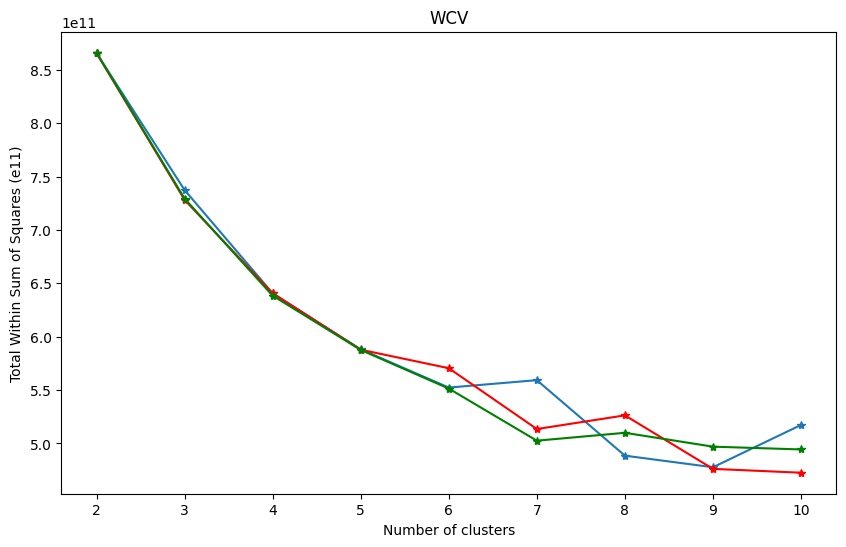

In [37]:
plt.figure(figsize=(10,6))
plt.plot(elbow_method_x,elbow_method_y, marker='*')
plt.plot(elbow_method_x_test2, elbow_method_y_test2, marker="*", color='red')
plt.plot(elbow_method_x_test3, elbow_method_y_test3, marker="*", color='green')
plt.xlabel('Number of clusters')
plt.ylabel('Total Within Sum of Squares (e11)')
plt.title('WCV')
plt.show()

### Kmeans - N_INIT = 5

In [38]:
elbow_method_x = []
elbow_method_y = []
for k in range(2,11):
    clusters, inertia = kmeans_model_predict(gene_train_df.T, k, n_init=5)
    elbow_method_x.append(k)
    elbow_method_y.append(inertia)

In [39]:
elbow_method_x_test2 = []
elbow_method_y_test2 = []
for k in range(2,11):
    clusters, inertia = kmeans_model_predict(gene_train_df.T, k,n_init=5)
    elbow_method_x_test2.append(k)
    elbow_method_y_test2.append(inertia)

In [40]:
elbow_method_x_test3 = []
elbow_method_y_test3 = []
for k in range(2,11):
    clusters, inertia = kmeans_model_predict(gene_train_df.T, k,n_init=5)
    elbow_method_x_test3.append(k)
    elbow_method_y_test3.append(inertia)

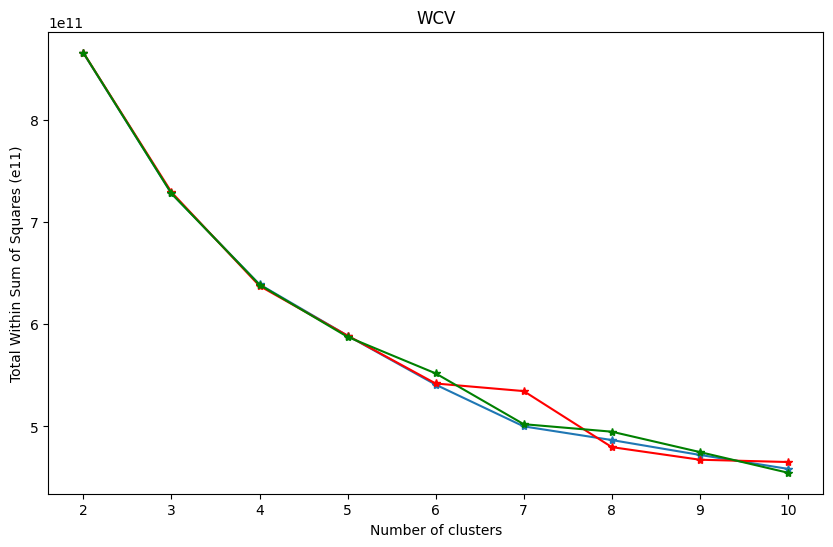

In [41]:
plt.figure(figsize=(10,6))
plt.plot(elbow_method_x,elbow_method_y, marker='*')
plt.plot(elbow_method_x_test2, elbow_method_y_test2, marker="*", color='red')
plt.plot(elbow_method_x_test3, elbow_method_y_test3, marker="*", color='green')
plt.xlabel('Number of clusters')
plt.ylabel('Total Within Sum of Squares (e11)')
plt.title('WCV')
plt.show()

### Kmeans - N_INIT = 10

In [42]:
elbow_method_x = []
elbow_method_y = []
for k in range(2,11):
    clusters, inertia = kmeans_model_predict(gene_train_df.T, k, n_init=10)
    elbow_method_x.append(k)
    elbow_method_y.append(inertia)

In [43]:
elbow_method_x_test2 = []
elbow_method_y_test2 = []
for k in range(2,11):
    clusters, inertia = kmeans_model_predict(gene_train_df.T, k,n_init=10)
    elbow_method_x_test2.append(k)
    elbow_method_y_test2.append(inertia)

In [44]:
elbow_method_x_test3 = []
elbow_method_y_test3 = []
for k in range(2,11):
    clusters, inertia = kmeans_model_predict(gene_train_df.T, k,n_init=10)
    elbow_method_x_test3.append(k)
    elbow_method_y_test3.append(inertia)

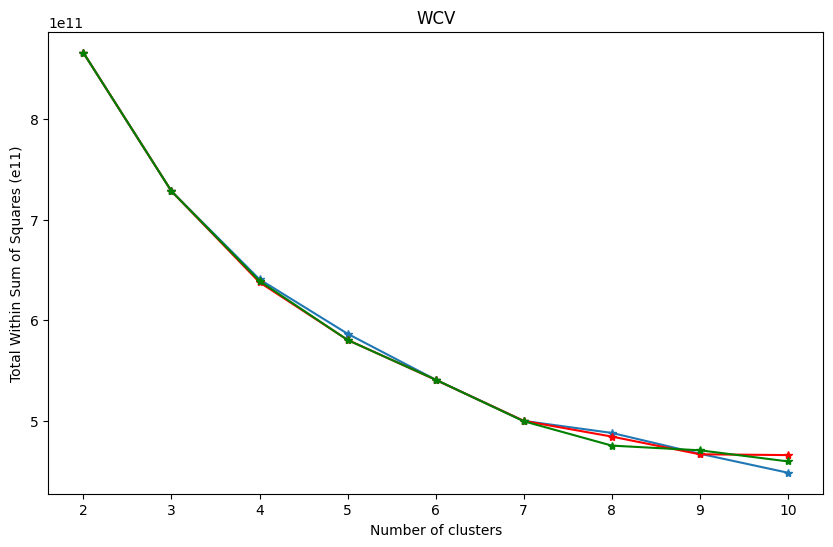

In [45]:
plt.figure(figsize=(10,6))
plt.plot(elbow_method_x,elbow_method_y, marker='*')
plt.plot(elbow_method_x_test2, elbow_method_y_test2, marker="*", color='red')
plt.plot(elbow_method_x_test3, elbow_method_y_test3, marker="*", color='green')
plt.xlabel('Number of clusters')
plt.ylabel('Total Within Sum of Squares (e11)')
plt.title('WCV')
plt.show()

### KMeans - Cluster Evaluation (K = 3)

In [85]:
clusters_number = 3
experiments_number = 2

In [46]:
clusters_test1, inertia = kmeans_model_predict(gene_train_df.T, 3, n_init=1)
cancer_count_percluster_test1 = output_creation(clusters_test1, cancer_categories_df, cancer_labels )

In [ ]:
cancer_count_percluster_test1

In [48]:
clusters_test2, inertia = kmeans_model_predict(gene_train_df.T, 3,n_init=1)
cancer_count_percluster_test2 = output_creation(clusters_test2, cancer_categories_df, cancer_labels )

In [ ]:
cancer_count_percluster_test2

In [86]:
cancer_count_bycluster_test1 = pd.DataFrame(cancer_count_percluster_test1, columns=cancer_labels)
cancer_count_bycluster_test2 = pd.DataFrame(cancer_count_percluster_test2, columns=cancer_labels)
cancer_count_bycluster = pd.concat([cancer_count_bycluster_test1, cancer_count_bycluster_test2 ], ignore_index=True)

In [89]:
cluster_experiments = create_cluster_string(clusters_number, experiments_number)
cancer_count_bycluster.insert(0, 'Cluster', cluster_experiments)

In [90]:
cancer_count_bycluster

,Cluster,breast,prostate,lung,collerectal,lymphoma,bladder,melanoma,uterus,leukemia,renal,pancreas,ovary,meso,cns
0,Cluster1_Test1,8,3,8,6,2,8,7,5,0,7,7,5,6,2
1,Cluster2_Test1,0,1,0,1,6,0,0,0,0,0,0,0,1,14
2,Cluster3_Test1,0,4,0,1,8,0,1,3,24,1,1,3,1,0
3,Cluster1_Test2,8,2,6,5,1,7,5,3,0,5,6,4,4,2
4,Cluster2_Test2,0,3,2,3,12,1,3,3,2,2,2,2,4,14
5,Cluster3_Test2,0,3,0,0,3,0,0,2,22,1,0,2,0,0


### KMeans - Cluster Evaluation (K = 6)

In [95]:
clusters_number = 6
experiments_number = 2

In [105]:
# Test 1
clusters_test1, inertia = kmeans_model_predict(gene_train_df.T, clusters_number, n_init=1)
cancer_count_percluster_test1 = output_creation(clusters_test1, cancer_categories_df, cancer_labels )
# Test 2
clusters_test2, inertia = kmeans_model_predict(gene_train_df.T, clusters_number,n_init=1)
cancer_count_percluster_test2 = output_creation(clusters_test2, cancer_categories_df, cancer_labels )

In [108]:
cancer_count_bycluster_test1 = pd.DataFrame(cancer_count_percluster_test1, columns=cancer_labels)
cancer_count_bycluster_test2 = pd.DataFrame(cancer_count_percluster_test2, columns=cancer_labels)
cancer_count_bycluster = pd.concat([cancer_count_bycluster_test1, cancer_count_bycluster_test2 ], ignore_index=True)

In [109]:
cluster_experiments = create_cluster_string(clusters_number, experiments_number)
cancer_count_bycluster.insert(0, 'Cluster', cluster_experiments)

In [117]:
cancer_count_bycluster

,Cluster,breast,prostate,lung,collerectal,lymphoma,bladder,melanoma,uterus,leukemia,renal,pancreas,ovary,meso,cns
0,Cluster1_Test1,7,1,6,3,0,6,3,3,0,3,4,4,2,1
1,Cluster2_Test1,1,3,2,4,1,2,4,2,0,4,3,1,4,1
2,Cluster3_Test1,0,4,0,1,0,0,1,3,0,1,1,3,1,0
3,Cluster4_Test1,0,0,0,0,15,0,0,0,6,0,0,0,1,0
4,Cluster5_Test1,0,0,0,0,0,0,0,0,18,0,0,0,0,0
5,Cluster6_Test1,0,0,0,0,0,0,0,0,0,0,0,0,0,14
6,Cluster1_Test2,7,3,6,4,0,6,4,3,0,3,4,4,3,3
7,Cluster2_Test2,1,1,2,3,1,2,3,2,0,4,3,1,3,3
8,Cluster3_Test2,0,4,0,1,0,0,1,3,0,1,1,3,1,0
9,Cluster4_Test2,0,0,0,0,15,0,0,0,6,0,0,0,1,0


### KMeans - Cluster Evaluation (K = 9)

In [118]:
clusters_number = 9
experiments_number = 2

In [119]:
# Test 1
clusters_test1, inertia = kmeans_model_predict(gene_train_df.T, clusters_number, n_init=1)
cancer_count_percluster_test1 = output_creation(clusters_test1, cancer_categories_df, cancer_labels )
# Test 2
clusters_test2, inertia = kmeans_model_predict(gene_train_df.T, clusters_number,n_init=1)
cancer_count_percluster_test2 = output_creation(clusters_test2, cancer_categories_df, cancer_labels )

In [120]:
cancer_count_bycluster_test1 = pd.DataFrame(cancer_count_percluster_test1, columns=cancer_labels)
cancer_count_bycluster_test2 = pd.DataFrame(cancer_count_percluster_test2, columns=cancer_labels)
cancer_count_bycluster = pd.concat([cancer_count_bycluster_test1, cancer_count_bycluster_test2 ], ignore_index=True)

In [121]:
cluster_experiments = create_cluster_string(clusters_number, experiments_number)
cancer_count_bycluster.insert(0, 'Cluster', cluster_experiments)

In [122]:
cancer_count_bycluster

,Cluster,breast,prostate,lung,collerectal,lymphoma,bladder,melanoma,uterus,leukemia,renal,pancreas,ovary,meso,cns
0,Cluster1_Test1,7,1,6,4,0,6,4,3,0,2,4,4,3,0
1,Cluster2_Test1,1,1,2,3,2,2,3,2,0,3,3,1,3,0
2,Cluster3_Test1,0,2,0,0,0,0,0,0,0,2,0,0,0,2
3,Cluster4_Test1,0,4,0,1,0,0,1,2,0,1,1,3,1,0
4,Cluster5_Test1,0,0,0,0,14,0,0,0,6,0,0,0,1,0
5,Cluster6_Test1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
6,Cluster7_Test1,0,0,0,0,0,0,0,0,18,0,0,0,0,0
7,Cluster8_Test1,0,0,0,0,0,0,0,0,0,0,0,0,0,12
8,Cluster9_Test1,0,0,0,0,0,0,0,0,0,0,0,0,0,2
9,Cluster1_Test2,4,1,4,2,0,6,3,3,0,3,3,4,1,1
